In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random

from sklearn.cluster import KMeans

import collections

In [36]:
# Remove the outliers
def remove_outliers(file_path):
    # return the list of dataframes
    dataframe_lists = []
    # Creating the dataframe and selecting the required columns
    for i in range(20):
        df = pd.read_csv(file_path, usecols=[1,2,3,4], skiprows=i*72000, nrows = 72000, names=["lz","X","Y","Z"])
        df['radiusSquare'] = df['X']*df['X']+df['Y']*df['Y']+df['Z']*df['Z']
        df['radius'] = np.sqrt(df['radiusSquare']).round(1)
        df['freq'] = df.groupby(['lz','radius'])['radius'].transform('count')
        for j in range(64):
            maxfreq = df[(df['lz']==j) & (df['radius']!=0)]['freq'].max()
            while maxfreq>100:
                df.drop(df[(df['lz']==j) & (df['freq']==maxfreq)].index, inplace=True)
                maxfreq = df[(df['lz']==j) & (df['radius']!=0)]['freq'].max()
                df.drop(df[(df['lz']==j) & (df['radius']==0)].index, inplace=True)
        dataframe_lists.append(df.iloc[:,1:4])
    return dataframe_lists

In [37]:
# atm = remove_outliers("/home/kia/Collected-Datasets/DEBS2019/debs2019_initial_dataset/Atm/in.csv")

# This the second data set that contains multiple objects
allData= remove_outliers("/home/kia/Collected-Datasets/DEBS2019/debs2019_dataset2/in.csv")

for i in range(20):
    print(allData[i]['X'].min() , allData[i]['X'].max())
    print(allData[i]['Z'].min() , allData[i]['Z'].max())
# min is -120  and max is 120 


-110.079773 99.703156
-119.380234 116.802673
-115.195 112.836441
-108.420158 110.719475
-94.480522 101.148933
-119.451668 118.771019
-115.498901 116.871895
-84.508873 88.650444
-113.325226 119.297836
-84.508873 113.46001399999999
-118.925529 88.583054
-119.597282 88.650444
-119.80186499999999 116.199532
-94.16327700000001 110.686752
-118.792603 93.706863
-119.126976 117.38418600000001
-111.93838500000001 119.624825
-119.00476100000002 116.842735
-112.967575 114.216225
-116.169785 118.374329
-111.030449 119.540085
-119.43854499999999 111.695618
-119.53273 119.643303
-101.152969 119.45645900000001
-118.16638200000001 117.353897
-119.063507 119.329567
-101.63906899999999 104.751335
-84.508873 111.892303
-108.26624299999999 101.85449200000001
-114.96280700000001 113.912376
-119.19760900000001 100.059875
-114.20552099999999 107.60929099999998
-96.92002099999999 110.001999
-117.207001 108.20092
-105.217751 112.511124
-114.989571 117.711891
-117.77366599999999 94.884445
-119.440628 118.976425

In [38]:
def isInt(value):
    try:
        int(value)
        return True
    except:
        return False


numOfObjects = []

# Out put data.
# We need to get the number of objects. 
pathOutput="/home/kia/Collected-Datasets/DEBS2019/debs2019_dataset2/out.csv"

with open(pathOutput) as fp:  
   line = fp.readline()
   cnt = 1
   while line:
    # print("Line {}: {}".format(cnt, line.strip()))
        lineArr=line.split(",")
        num = 0
        for index in range(1, len(lineArr)):
            if(isInt(lineArr[index])):
               num +=int(lineArr[index])
        numOfObjects.append(num)
        #print(line.split(",")[1])
        line = fp.readline()
        cnt += 1
        
        
        
print(max(numOfObjects))

print("-------------")
for i in range(10):
    print(numOfObjects[i])


50
-------------
33
25
25
17
16
34
35
20
17
32


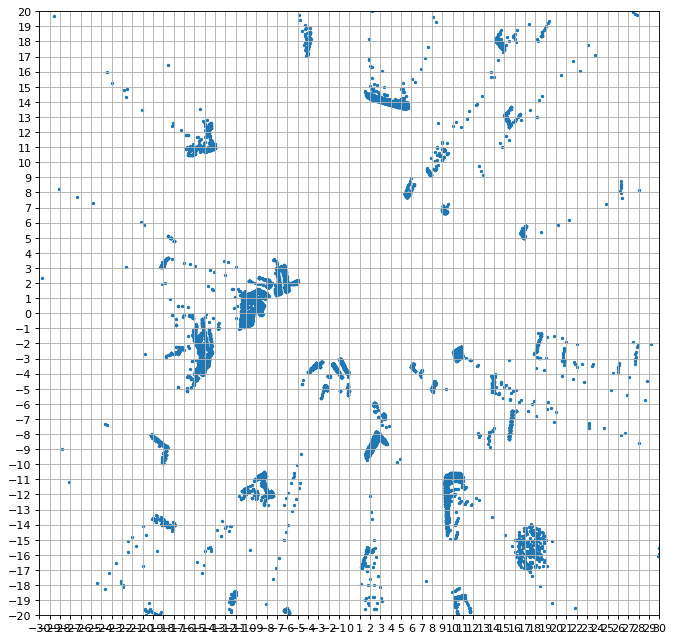

In [39]:
grid_size= 1
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.gca()
ax.set_xticks(np.arange(-120, 120, grid_size))
ax.set_yticks(np.arange(-120, 120, grid_size))
# plt.grid()
plt.scatter(allData[0]['Z'], allData[0]['X'], s=4)
plt.xlim(-30, 30)
plt.ylim(-20, 20)
plt.grid()
plt.show()

In [40]:
def transformToSuperCells_new(x, y, cuttOffData=0.75):

    tuplesData = np.array(list(zip(x, y)))

    # We hash on x^4 + y^2, so that we can have unique hash for each tuple.  
    hashedData = np.array(list(map(hash, x.astype(np.int32)**4+ y.astype(np.int32)**2 )))

    # https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
    # import collections
    countsDict=collections.Counter(hashedData)

    # keys1 = np.asarray(list(countsDict))
    values1 = np.fromiter(countsDict.values(), dtype=int)
    # print(keys1)
    # print("Mean", np.mean(values1))
    
    # Remove all of the data that is smaller than mean. 
    mean=np.mean(values1)

    finalX=np.array([])
    finalY=np.array([])

    for i in range(x.size):
        hashKey = hash(int(x[i])**4 + int(y[i])**2)
        if(hashKey in countsDict):
            if(countsDict[hashKey] > mean):
                # sample data based on the cuttOff here 0.75
                if(random.uniform(0, 1) > cuttOffData):
                    finalX= np.append(finalX, x[i])
                    finalY= np.append(finalY, y[i])
    
    
    return  np.array(list(zip(finalX, finalY)))

In [41]:
#
def doClustering(data, min_cluster_number=10, max_cluster_number=50, Elbow_ratio = 1.2):
    Sum_of_squared_distances = []

    
    for k in range(min_cluster_number, max_cluster_number):
        if(data.size <= k):
            break
        km = KMeans(n_clusters=k, max_iter=100, random_state=0)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)

    numberOfClusters = 1
    for i in range(1, len(Sum_of_squared_distances)):
        ratio=float((Sum_of_squared_distances[i-1])/Sum_of_squared_distances[i])
        # elbow ratio is an important parameter. 
        if(ratio < Elbow_ratio):
            numberOfClusters=i+1
            break
    # final run with large iterations 
    km = KMeans(n_clusters=numberOfClusters, max_iter=100, random_state=0)
    km = km.fit(data)
    # print(km.cluster_centers_)
    
    return numberOfClusters, km.cluster_centers_

Data size:  13678 Sample size:  (1257, 2) Number Of Clusters:  34 , Difference is:  -1


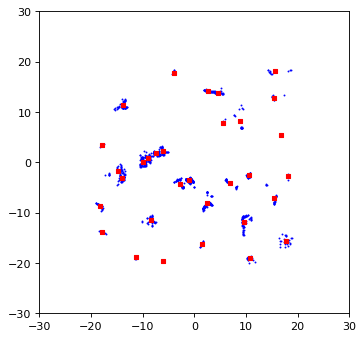

Next Scene --------------------------------- ... 
Data size:  13320 Sample size:  (1075, 2) Number Of Clusters:  26 , Difference is:  -1


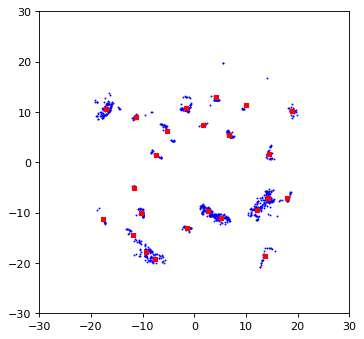

Next Scene --------------------------------- ... 
Data size:  11508 Sample size:  (1017, 2) Number Of Clusters:  21 , Difference is:  4


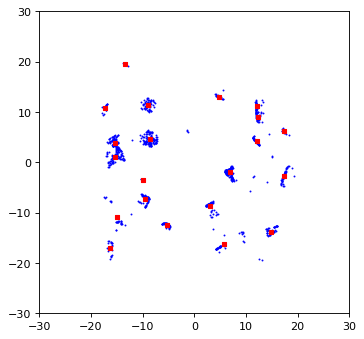

Next Scene --------------------------------- ... 
Data size:  11178 Sample size:  (1039, 2) Number Of Clusters:  9 , Difference is:  8


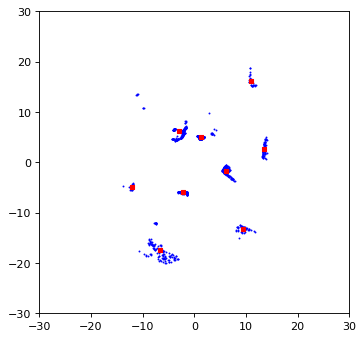

Next Scene --------------------------------- ... 


In [42]:
# run a test. 


for i in range(4):
    fig = plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.gca()
    
    setAgg = transformToSuperCells_new(np.array(allData[i]['Z']), np.array(allData[i]['X']), cuttOffData=0.9)



    # setAgg = np.array(list(zip(allData[i]['Z'], allData[i]['X'])))
    numberOfClusters, cluster_centers = doClustering(setAgg , min_cluster_number=10, Elbow_ratio = 1.04)
    print("Data size: ", np.array(allData[i]['Z']).size, "Sample size: ", setAgg.shape, 
          "Number Of Clusters: ", numberOfClusters, ", Difference is: ", numOfObjects[i] - numberOfClusters)
    plt.scatter(setAgg[:,0], setAgg[:,1],  c='blue', s=0.5)
    plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker=",",  c='red', s=14)
    plt.xlim(-30, 30)
    plt.ylim(-30, 30)
    plt.show()
    print("Next Scene --------------------------------- ... ")